In [8]:
import warnings
import json
import pandas as pd
import torch
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoModelForMaskedLM, AutoTokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments

In [9]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False  # 启用Cudnn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
warnings.filterwarnings('ignore')

# 创建自定义数据集类
class CitationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, block_size=256):
        self.examples = []
        for text in texts:
            tokenized_text = tokenizer(text, truncation=True, padding='max_length', max_length=block_size, return_tensors='pt')
            self.examples.append(tokenized_text['input_ids'].squeeze())

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return self.examples[i]

df_unlabeled = pd.read_csv('../data/citing_paper_contexts_unlabeled.csv')
print(df_unlabeled.shape)
texts = df_unlabeled['text'].tolist()
df_unlabeled.head()

(42091, 3)


,text,label_score,label
0,"Instead of mixing the representations, G-Mixup...",NaN,NaN
1,Graph Data Augmentation DropEdge [131] Randoml...,NaN,NaN
2,DropEdge [131] Randomly remove edges Perturbat...,NaN,NaN
3,"For G-Mixup, we use the same hyper-parameters ...",NaN,NaN
4,Few works have proposed methods to adapt mixup...,NaN,NaN


In [11]:
def load_intent_datasets():
    label2id = {"background": 0, "method": 1, "result": 2}
    id2label = {v: k for k, v in label2id.items()}

    def read_jsonl(file_path):
        citations = []
        intents = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                entry = json.loads(line.strip())
                citation = entry.get('citation')
                citation_intent = entry.get('citation_intent')
                if citation and citation_intent:
                    citation_intent_id = label2id.get(citation_intent, -1)  # Use -1 for unknown labels
                    citations.append(citation)
                    intents.append(citation_intent_id)
        return citations, intents

    train_citations, train_intents = read_jsonl('../data/controllable-citation-generation/train.jsonl')
    test_citations, test_intents = read_jsonl('../data/controllable-citation-generation/test.jsonl')
    val_citations, val_intents = read_jsonl('../data/controllable-citation-generation/val.jsonl')
    return train_citations, train_intents, val_citations, val_intents, test_citations, test_intents

train_citations, _, val_citations, _, test_citations, _ = load_intent_datasets()
texts = train_citations + val_citations + test_citations + texts

In [12]:
base_model_name = 'roberta-llama3.1405B-twitter-sentiment'
BASE_MODEL_PATH = f'../pretrain_models/{base_model_name}'
model = AutoModelForMaskedLM.from_pretrained(BASE_MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)
tokenizer.save_pretrained(f'../citation_finetuned_models/{base_model_name}_cpt')

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at ../pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('../citation_finetuned_models/roberta-llama3.1405B-twitter-sentiment_cpt\\tokenizer_config.json',
 '../citation_finetuned_models/roberta-llama3.1405B-twitter-sentiment_cpt\\special_tokens_map.json',
 '../citation_finetuned_models/roberta-llama3.1405B-twitter-sentiment_cpt\\vocab.json',
 '../citation_finetuned_models/roberta-llama3.1405B-twitter-sentiment_cpt\\merges.txt',
 '../citation_finetuned_models/roberta-llama3.1405B-twitter-sentiment_cpt\\added_tokens.json',
 '../citation_finetuned_models/roberta-llama3.1405B-twitter-sentiment_cpt\\tokenizer.json')

Step,Training Loss,Validation Loss
250,No log,8.069451
500,9.353700,6.425076
750,9.353700,5.043561
1000,5.415400,4.355700
1250,5.415400,3.908490
1500,4.148900,3.572396
1750,4.148900,3.303965
2000,3.502100,3.073555
2250,3.502100,2.923245
2500,3.152800,2.795707


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


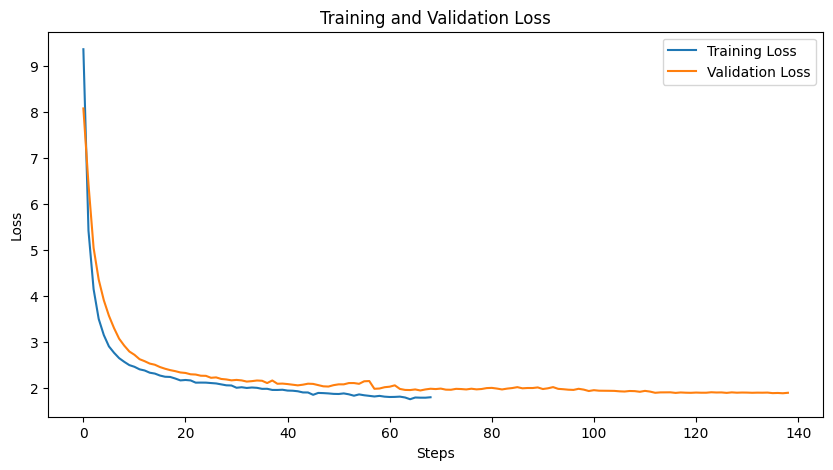

In [13]:
from transformers import TrainerCallback

train_texts, valid_texts = train_test_split(texts, test_size=0.2, random_state=seed)
train_dataset = CitationDataset(train_texts, tokenizer)
valid_dataset = CitationDataset(valid_texts, tokenizer)

class LossRecorderCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.eval_losses, label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()
        
    
loss_recorder = LossRecorderCallback()    
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
training_args = TrainingArguments(
    output_dir=f'./results/itft_{base_model_name}',  # select model path for checkpoint
    overwrite_output_dir=True,
    num_train_epochs=3,  # 轮数不要设置的太大
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    warmup_ratio=0.1,
    evaluation_strategy='steps',
    disable_tqdm=False,
    save_total_limit=2,
    eval_steps=250,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    prediction_loss_only=True,
    report_to="none")

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[loss_recorder]
)

trainer.train()
trainer.save_model(f'../citation_finetuned_models/{base_model_name}_cpt')
loss_recorder.plot_losses()